# $\color{palevioletred}{\text{Negation and Uncertainty Detection: Rule-Based and Deep Learning Approaches}}$

---

## Project Description

---

The project focuses on developing effective methods for detecting negation and uncertainty cues in natural language text. It employs both rule-based and deep learning approaches to tackle this task.

In the rule-based approach, a set of predefined linguistic rules and patterns are designed to identify and extract negation and uncertainty cues.

In contrast, the deep learning approach utilizes neural network models. This models are trained using labeled data, where input text samples are associated with annotations indicating the presence of negation and uncertainty cues, as well as their scopes. 

The project's ultimate goal is to develop a robust and accurate system for negation and uncertainty detection in natural language.

---

## Initialization

---


### $\color{palevioletred}{\text{(1) Loading Modules and Dependencies}}$

In [ ]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install negspacy
!{sys.executable} -m pip install spacy_stanza 

In [ ]:
!pip install wandb

In [2]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Needed libraries
import json
import os
import pickle

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchtext

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from collections import Counter

from prettytable import PrettyTable

#import wandb

import spacy
import stanza
import spacy_stanza

from torchtext.vocab import Vocab
from torch.utils.data import Dataset

from colorama import Fore, Style
import textwrap

import random
import math

import re

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

- Loading data

In [7]:
with open("negacio_uab_revised_version.json", "r", encoding="utf-8") as f:
    data = json.load(f)

---

## Rule-Based Approach

---



### $\color{palevioletred}{\text{(1) First attempt}}$

To start with, we thought on the most basic approach for the rule-based method, which consisted in the use of a fixed-size window. After that, we thought on another way to approach this: by looking at the part of speech tags of each word, and adding all the words after a cue, and stops when finds a given pattern.

In [ ]:
# Store in lists data that could be useful later on
texts = []
start = []
end = []
labels = []

for i in range(len(data)):
    if i != 183:
        texts.append(data[i]['data']['text'])
        start.append(data[i]['predictions'][0]['result'][0]['value']['start'])
        end.append(data[i]['predictions'][0]['result'][0]['value']['end'])
        labels.append(data[i]['predictions'][0]['result'][0]['value']['labels'][0])

Define some rules, extracting the words whose labels are 'NEG' or 'UNC', so that we can have an idea of cues that usually appear in real diagnoses.

In [ ]:
# Define the rules
rules = []
negation_words = []
uncertainty_words = []

for text, start_ind, end_ind, label in zip(texts, start, end, labels):
  if label == 'NEG':
    if text[start_ind:end_ind-1] not in negation_words:
      negation_words.append(text[start_ind:end_ind-1])
  elif label == 'UNC':
    if text[start_ind:end_ind-1] not in uncertainty_words:
      uncertainty_words.append(text[start_ind:end_ind-1])

In [ ]:
# Create a list of dictionaries
for neg_word in negation_words:
  rules.append({'keyword': neg_word, 'category': 'NEG'})

for unc_word in uncertainty_words:
  rules.append({'keyword': unc_word, 'category': 'UNC'})

rules

[{'keyword': 'sin', 'category': 'NEG'},
 {'keyword': 'no', 'category': 'NEG'},
 {'keyword': 'ex-fumador', 'category': 'NEG'},
 {'keyword': 'negativo', 'category': 'NEG'},
 {'keyword': 'niega', 'category': 'NEG'},
 {'keyword': 'neg', 'category': 'NEG'},
 {'keyword': 'nega', 'category': 'NEG'},
 {'keyword': 'negativa', 'category': 'NEG'},
 {'keyword': 'inestabilidad', 'category': 'NEG'},
 {'keyword': 'niegan', 'category': 'NEG'},
 {'keyword': 'desorientacion', 'category': 'NEG'},
 {'keyword': 'sense', 'category': 'NEG'},
 {'keyword': 'ex fumador', 'category': 'NEG'},
 {'keyword': 'probable', 'category': 'UNC'},
 {'keyword': 'sugestivo de', 'category': 'UNC'},
 {'keyword': 'sospecha de', 'category': 'UNC'},
 {'keyword': 'dudoso', 'category': 'UNC'},
 {'keyword': 'sospecha', 'category': 'UNC'},
 {'keyword': 'compatible con', 'category': 'UNC'},
 {'keyword': 'posible', 'category': 'UNC'},
 {'keyword': 'probablemente', 'category': 'UNC'},
 {'keyword': 'sospechosa de', 'category': 'UNC'}]

- Loading spacy_stanza pipeline.

In [ ]:
nlp = spacy_stanza.load_pipeline('es', package='ancora') #spanish

- Function definitions

Function to clean tokens: it keeps the text from the word "informe" to the end, since before that word is irrelevant information about the patient, and also removes punctuations.

In [ ]:
def clean(tokens):
  # Start text at word 'informe'
  try:
    start_index = tokens.index('informe')
    tokens = tokens[start_index:]
  except ValueError:
    pass

  # Remove punctuations
  tokens = [token.lower() for token in tokens if token not in [',', '.', '(', ')', '-', '*', ':', '%', '/']]

  return tokens

Function to look for negation and uncertainty words. If they are neither of them, categorize them as unkown.

In [ ]:
def categorize(text):
    for rule in rules:
        if text.lower() == rule['keyword']:
            return rule['category']
    return 'unknown'

Function to obtain part of speech tags in a dictionary, with spacy library.

In [ ]:
def obtain_tags(text):
  tags = []

  doc = nlp(text)
  for token in doc:
    word, pos_tag = token.text, token.pos_
    tags.append((token.text, token.pos_))
  
  return tags

Function to obtain scopes. It receives a list of tokens and creates a window of default size of four after a cue that will make up the scope.

In [ ]:
def obtain_scopes(tokens, window_size=4):
  scopes = []

  for i in range(len(tokens)):
    if categorize(tokens[i]) != 'unknown':
      scope = []
      try:
        for j in range(i+1, i+window_size+1):
          scope.append(tokens[j])
      except IndexError:
        pass
      scope = ' '.join(scope)
      scopes.append((categorize(tokens[i]), tokens[i], scope))

  return scopes

Another way we to obtain a scope with a window, similar to the example before: look for a pattern of NOUN + ADJ. After a cue, it creates a window that will be from the cue, until this pattern.

In [ ]:
def obtain_scopes2(pos_tags, rules):
  dict_scopes = []
  bol = False

  for ind, (word, tag) in enumerate(pos_tags):
    scope = []
    word = word.lower()
    if word in rules:
      for i in range(ind, len(pos_tags)):
        for j in range(ind+1, len(pos_tags)):
          if (pos_tags[j][1] == 'NOUN') and (pos_tags[j+1][1] == 'ADJ'):
            start = i+1
            end = j+2
            while start != end:
              scope.append(pos_tags[start][0])
              start += 1
            scope = ' '.join(scope)
            dict_scopes.append((categorize(word), word, scope))
            bol = True
            break
        if bol == True:
          break

  return dict_scopes

Before applying this functions to the real text, let's see if they work, with a smaller example.

In [ ]:
train_example = """El paciente tiene dolencias pero no hay presencia de alergias medicamentosas en él.
Sin incidencias postquirúrgicas que hayan dañado el tejido cerebral. No muestra síntomas de cardiopatía congénita.
Tenemos sospecha de una enfermedad patológica con posible afectación en la válvula tricúspide. 
El paciente está sin previos registros médicos."""

test_example = ['no hay presencia de alergias medicamentosas', 'Sin incidencias postquirúrgicas', 
                'No muestra síntomas de cardiopatía congénita', 'sospecha de una enfermedad patológica', 
                'posible afectación en la válvula tricúspide', 'sin previos registros médicos']

cue_example = [('NEG', 'no'), ('NEG', 'Sin'), ('NEG', 'No'), ('UNC', 'sospecha'), ('UNC', 'posible'), ('NEG', 'sin')]

**Testing fixed-size window approach on the train example.** Tokenize words, clean them, and obtain the scopes.

In [ ]:
pos_tags = obtain_tags(train_example)
tokenized_words = [text for text, tag in pos_tags]

scopes_window_example = obtain_scopes(clean(tokenized_words))
scopes_window_example

[('NEG', 'no', 'hay presencia de alergias'),
 ('NEG', 'sin', 'incidencias postquirúrgicas que hayan'),
 ('NEG', 'no', 'muestra síntomas de cardiopatía'),
 ('UNC', 'sospecha', 'de una enfermedad patológica'),
 ('UNC', 'posible', 'afectación en la válvula'),
 ('NEG', 'sin', 'previos registros médicos')]

**Testing PoS tagging approach on train example.** Obtain the cues from the rules, obtain the PoS tags, and pass them to the function to obtain scopes.

In [ ]:
neg_unc_words = [rule['keyword'] for rule in rules]
pos_tags = obtain_tags(train_example)
scopes_tags_example = obtain_scopes2(pos_tags, neg_unc_words)
scopes_tags_example

[('NEG', 'no', 'hay presencia de alergias medicamentosas'),
 ('NEG', 'sin', 'incidencias postquirúrgicas'),
 ('NEG', 'no', 'muestra síntomas de cardiopatía congénita'),
 ('UNC', 'sospecha', 'de una enfermedad patológica'),
 ('UNC', 'posible', 'afectación en la válvula tricúspide'),
 ('NEG', 'sin', 'previos registros médicos')]

Now that we have seen that the functions do work, we can apply them on the real diagnoses. The tests and evaluations will be done on the first diagnosis.

**Testing fixed-size window on real diagnoses.**

In [ ]:
pos_tags = obtain_tags(texts[0])
tokenized_words = [text for text, tag in pos_tags]

predicted_scopes_window = obtain_scopes(clean(tokenized_words))
predicted_scopes_window

/usr/local/lib/python3.10/dist-packages/spacy/language.py:999: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/usr/local/lib/python3.10/dist-packages/spacy/language.py:999: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['nº', 'historia', 'clinica', ':', '**', '***', '***', 'nºepisodi', ':', '********', 'sexe', ':', 'dona', 'data', 'de', 'naixement', ':', '06.06.1938', 'edat', ':', '79', 'anys', 'procedencia', 'domicil/res', '.soc', 'servei', 'psiquiatria', 'data', "d'ingres", '10.05.2018', 'data', "d'alta", '10.05.2018', '16:46:41', 'ates', 'per', '****************', ',', '************', ';', '*************', ',', 'assumpta', 'informe', "d'alta", "d'hospitalitzacio", 'motiu', "d'ingres", 'paciente', 'de', '79', 'años', 'que', 'acude', 

[('NEG', 'sin', 'alergias mediamentosas conocidas hipertension'),
 ('NEG', 'sin', 'hijos tiene un hermano'),
 ('NEG', 'no', 'refiriendo una ideacion suicida'),
 ('NEG', 'sin', 'alteraciones en el contenido'),
 ('NEG', 'no', 'evidenciando alteraciones endogenomorfas en'),
 ('NEG', 'no', 'ideacion suicida estructurada en'),
 ('NEG', 'no', 'alteraciones en la sensopercepcion'),
 ('NEG', 'no', 'auto ni heteroagresiva normosomnia')]

**Testing PoS tagging on medical diagnoses.**

In [ ]:
pos_tags = obtain_tags(texts[0])
predicted_scopes_tags = obtain_scopes2(pos_tags, neg_unc_words)
predicted_scopes_tags

/usr/local/lib/python3.10/dist-packages/spacy/language.py:999: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/usr/local/lib/python3.10/dist-packages/spacy/language.py:999: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['nº', 'historia', 'clinica', ':', '**', '***', '***', 'nºepisodi', ':', '********', 'sexe', ':', 'dona', 'data', 'de', 'naixement', ':', '06.06.1938', 'edat', ':', '79', 'anys', 'procedencia', 'domicil/res', '.soc', 'servei', 'psiquiatria', 'data', "d'ingres", '10.05.2018', 'data', "d'alta", '10.05.2018', '16:46:41', 'ates', 'per', '****************', ',', '************', ';', '*************', ',', 'assumpta', 'informe', "d'alta", "d'hospitalitzacio", 'motiu', "d'ingres", 'paciente', 'de', '79', 'años', 'que', 'acude', 

[('NEG', 'sin', 'alergias mediamentosas'),
 ('NEG',
  'sin',
  'hijos . tiene un hermano con el que tiene contacto en barcelona . vive en apartamentos tutelados'),
 ('NEG', 'no', 'refiriendo una ideacion suicida'),
 ('NEG',
  'sin',
  'alteraciones en el contenido de el pensamiento . humor resonante'),
 ('NEG', 'no', 'evidenciando alteraciones endogenomorfas'),
 ('NEG', 'no', 'ideacion suicida'),
 ('NEG',
  'no',
  'alteraciones en la sensopercepcion ni otras alteraciones dentro de la esfera psicotica'),
 ('NEG',
  'no',
  'auto ni heteroagresiva . normosomnia . normorexia . juicio de la realidad preservado')]

- **Evaluation**

To evaluate the performance, we create:
- accuracy_cues: testing the detection of cues
- accuracy_scopes: testing the detection of cues and their scopes
- accuracy_scopes2: testing the detection of cues and their scopes in a slightly different way (because the format of the example's prediction and diagnosis' prediction are not the same)

In [ ]:
def accuracy_cues(scopes, cue_test, labels = ['NEG', 'UNC']):
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0

  if len(scopes) > len(cue_test):
    while len(scopes) > len(cue_test):
      cue_test.append(('o', 'o'))
  elif len(cue_test) > len(scopes):
    while len(cue_test) > len(scopes):
      scopes.append(('o', 'o', 'o'))
      

  for (predicted_label, predicted_word, scope), (real_label, real_word) in zip(scopes, cue_test):
    predicted_word = predicted_word.lower()
    real_word = real_word.lower()

    if (predicted_label == real_label) and (predicted_label in labels):
      true_positives += 1

    elif  (predicted_label not in labels) and (predicted_label == real_label):
      true_negatives += 1

    elif (predicted_label != real_label) and (predicted_label in labels):
      false_positives += 1
    
    elif (predicted_label == 'o') and (real_label in labels):
      false_negatives += 1

  
  print("True Positives:", true_positives)
  print("True Negatives:",true_negatives)
  print("False Positives:", false_positives)
  print("False Negatives:",false_negatives)

  # Measures

  denominator = true_positives + false_positives

  if denominator == 0:
      precision = 0
  else:
      precision = true_positives / denominator

  denominator = true_positives + false_negatives

  if denominator == 0:
      recall = 0
  else:
      recall = true_positives / denominator

  denominator = true_positives + true_negatives + false_positives + false_negatives

  if denominator == 0:
      f1_score = 0
      accuracy = 0
  else:
      f1_score = 2 * (precision * recall) / (precision + recall)
      accuracy = (true_positives + true_negatives) / denominator

  x = PrettyTable()
  x.field_names = ["Measure", "Score"]
  x.add_row(["Precision", f"{precision:.2f}"])
  x.add_row(["Recall", f"{recall:.2f}"])
  x.add_row(["F1-score", f"{f1_score:.2f}"])
  x.add_row(["Accuracy", f"{accuracy:.2f}"])

  print(x)

In [ ]:
def accuracy_scopes(scope, test):
  correct = 0
  accuracy = 0

  true_negatives = 0
  true_positives= 0
  false_positives = 0
  false_negatives = 0

  for (label, key, value), sentence in zip(scope, test):
    prediction = key + ' ' + value
    real = nltk.word_tokenize(sentence)
    real = [x.lower() for x in real]
    predicted = nltk.word_tokenize(prediction)
    predicted = [x.lower() for x in predicted]
    if len(real) > len(predicted):
      predicted += 'o' * (len(real) - len(predicted))
    else:
      real += 'o' * (len(predicted) - len(real))

    print('Predicted scope:', predicted)
    print('Real scope', real)

    for real_token, predicted_token in zip(real, predicted):
        if real_token == predicted_token and real_token != 'o':
          true_positives += 1

        elif real_token == predicted_token:
          true_negatives += 1
        
        elif predicted_token != 'o' and real_token == 'o':
          false_positives += 1
        
        else:
          false_negatives += 1

  print("True Positives:", true_positives)
  print("True Negatives:",true_negatives)
  print("False Positives:", false_positives)
  print("False Negatives:",false_negatives)

  # Measures

  denominator = true_positives + false_positives

  if denominator == 0:
      precision = 0
  else:
      precision = true_positives / denominator

  denominator = true_positives + false_negatives

  if denominator == 0:
      recall = 0
  else:
      recall = true_positives / denominator

  denominator = true_positives + true_negatives + false_positives + false_negatives

  if denominator == 0:
      f1_score = 0
      accuracy = 0
  else:
      f1_score = 2 * (precision * recall) / (precision + recall)
      accuracy = (true_positives + true_negatives) / denominator

  x = PrettyTable()
  x.field_names = ["Measure", "Score"]
  x.add_row(["Precision", f"{precision:.2f}"])
  x.add_row(["Recall", f"{recall:.2f}"])
  x.add_row(["F1-score", f"{f1_score:.2f}"])
  x.add_row(["Accuracy", f"{accuracy:.2f}"])

  print(x)

In [ ]:
# Checks if two lists are similar depending on a threshold
def check_similar_lists(list1, list2, threshold):
  point = 0

  for x in list1:
    for y in list2:
      if x == y:
        point += 1
  
  if point > threshold:
    return True
  
  return False

In [ ]:
def accuracy_scopes2(scope, test, similarity):
  correct = 0
  accuracy = 0

  true_negatives = 0
  true_positives= 0
  false_positives = 0
  false_negatives = 0

  bol = False

  for true_label, true_scope in test:
    for label, key, predicted_scope in scope:
      
      real = nltk.word_tokenize(true_scope)
      real = [x.lower() for x in real]
      predicted = nltk.word_tokenize(predicted_scope)
      predicted = [x.lower() for x in predicted]

      if predicted[0] == real[0]:
        if predicted[0] == 'alteraciones' and check_similar_lists(predicted, real, similarity) == False:
          continue

        bol = True
        if len(real) > len(predicted):
          predicted += 'o' * (len(real) - len(predicted))
        else:
          real += 'o' * (len(predicted) - len(real))
        

        print('Predicted scope:', predicted)
        print('Real scope:', real, '\n')

        for real_token, predicted_token in zip(real, predicted):
          if real_token == predicted_token and real_token != 'o':
            true_positives += 1

          elif real_token == predicted_token:
            true_negatives += 1
            
          elif predicted_token != 'o' and real_token == 'o':
            false_positives += 1
            
          else:
            false_negatives += 1

      
    if bol == False:
      continue

  print("True Positives:", true_positives)
  print("True Negatives:",true_negatives)
  print("False Positives:", false_positives)
  print("False Negatives:",false_negatives)

  # Measures

  denominator = true_positives + false_positives

  if denominator == 0:
    precision = 0
  else:
    precision = true_positives / denominator

  denominator = true_positives + false_negatives

  if denominator == 0:
    recall = 0
  else:
    recall = true_positives / denominator

  denominator = true_positives + true_negatives + false_positives + false_negatives

  if denominator == 0:
    f1_score = 0
    accuracy = 0
  else:
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (true_positives + true_negatives) / denominator

  x = PrettyTable()
  x.field_names = ["Measure", "Score"]
  x.add_row(["Precision", f"{precision:.2f}"])
  x.add_row(["Recall", f"{recall:.2f}"])
  x.add_row(["F1-score", f"{f1_score:.2f}"])
  x.add_row(["Accuracy", f"{accuracy:.2f}"])

  print(x)

As well as that, we also need the true labels and the true scopes, so we will be defining:
- get_true_cues
- get_true_scopes

In [ ]:
def get_true_cues(data, num_text, texts):
  cues = []

  for j in range(len((data[num_text]['predictions'][0]['result']))):
      if data[num_text]['predictions'][0]['result'][j]['value']['labels'][0] == 'NEG':
        start = data[num_text]['predictions'][0]['result'][j]['value']['start']
        end = data[num_text]['predictions'][0]['result'][j]['value']['end']
        label = 'NEG'
        cue = texts[num_text][start:end-1]

      elif data[num_text]['predictions'][0]['result'][j]['value']['labels'][0] == 'UNC':
        start = data[num_text]['predictions'][0]['result'][j]['value']['start']
        end = data[num_text]['predictions'][0]['result'][j]['value']['end']
        cue = texts[num_text][start:end-1]
        label = 'UNC'
    
      cues.append((label, cue))
  return cues

In [ ]:
def get_true_scopes(data, num_text, texts):
    scopes = []
    USCO = []
    NSCO = []
        
    for j in range(len(data[num_text]['predictions'][0]['result'])):
      if data[num_text]['predictions'][0]['result'][j]['value']['labels'][0] == 'USCO':
        start = data[num_text]['predictions'][0]['result'][j]['value']['start']
        end = data[num_text]['predictions'][0]['result'][j]['value']['end']
        scopes.append(('USCO', texts[num_text][start:end]))

      elif data[num_text]['predictions'][0]['result'][j]['value']['labels'][0] == 'NSCO':
        start = data[num_text]['predictions'][0]['result'][j]['value']['start']
        end = data[num_text]['predictions'][0]['result'][j]['value']['end']
        scopes.append(('NSCO', texts[num_text][start:end]))
    
    return scopes

In [ ]:
true_cues = get_true_cues(data, 0, texts)
true_cues

[('NEG', 'sin'),
 ('NEG', 'no'),
 ('NEG', 'sin'),
 ('NEG', 'no'),
 ('NEG', 'no'),
 ('NEG', 'no'),
 ('NEG', 'no'),
 ('UNC', 'impresiona'),
 ('UNC', 'impresiona'),
 ('UNC', 'impresiona'),
 ('NEG', 'si'),
 ('NEG', 'si'),
 ('NEG', 'si'),
 ('NEG', 'si'),
 ('NEG', 'si'),
 ('NEG', 'si'),
 ('NEG', 'si'),
 ('NEG', 'si')]

In [ ]:
true_scopes = get_true_scopes(data, 0, texts)
true_scopes

[('USCO', 'deterioro cognitivo progresivo,'),
 ('NSCO', 'hijos'),
 ('NSCO', 'alergias mediamentosas conocidas'),
 ('NSCO', 'alteraciones en el contenido del pensamiento'),
 ('NSCO', 'evidenciando alteraciones endogenomorfas en el esatdo de animo'),
 ('NSCO', 'ideacion suicida estructurada en el momento actual'),
 ('NSCO',
  'alteraciones en la sensopercepcion ni otras alteraciones dentro de la esfera psicotica'),
 ('NSCO', 'auto ni heteroagresiva'),
 ('NSCO', 'refiriendo una ideacion suicida clara')]

Now that all is set up, we can test this first rule-based method, on both the train example, and the first real diagnosis.

In [ ]:
accuracy_scopes(scopes_window_example, test_example) # predicted scopes with nltk on train example

Predicted scope: ['no', 'hay', 'presencia', 'de', 'alergias', 'o']
Real scope ['no', 'hay', 'presencia', 'de', 'alergias', 'medicamentosas']
Predicted scope: ['sin', 'incidencias', 'postquirúrgicas', 'que', 'hayan']
Real scope ['sin', 'incidencias', 'postquirúrgicas', 'o', 'o']
Predicted scope: ['no', 'muestra', 'síntomas', 'de', 'cardiopatía', 'o']
Real scope ['no', 'muestra', 'síntomas', 'de', 'cardiopatía', 'congénita']
Predicted scope: ['sospecha', 'de', 'una', 'enfermedad', 'patológica']
Real scope ['sospecha', 'de', 'una', 'enfermedad', 'patológica']
Predicted scope: ['posible', 'afectación', 'en', 'la', 'válvula', 'o']
Real scope ['posible', 'afectación', 'en', 'la', 'válvula', 'tricúspide']
Predicted scope: ['sin', 'previos', 'registros', 'médicos']
Real scope ['sin', 'previos', 'registros', 'médicos']
True Positives: 27
True Negatives: 0
False Positives: 2
False Negatives: 3
+-----------+-------+
|  Measure  | Score |
+-----------+-------+
| Precision |  0.93 |
|   Recall  |  

In [ ]:
accuracy_scopes(scopes_tags_example, test_example) # predicted scopes with spacy on train example

Predicted scope: ['no', 'hay', 'presencia', 'de', 'alergias', 'medicamentosas']
Real scope ['no', 'hay', 'presencia', 'de', 'alergias', 'medicamentosas']
Predicted scope: ['sin', 'incidencias', 'postquirúrgicas']
Real scope ['sin', 'incidencias', 'postquirúrgicas']
Predicted scope: ['no', 'muestra', 'síntomas', 'de', 'cardiopatía', 'congénita']
Real scope ['no', 'muestra', 'síntomas', 'de', 'cardiopatía', 'congénita']
Predicted scope: ['sospecha', 'de', 'una', 'enfermedad', 'patológica']
Real scope ['sospecha', 'de', 'una', 'enfermedad', 'patológica']
Predicted scope: ['posible', 'afectación', 'en', 'la', 'válvula', 'tricúspide']
Real scope ['posible', 'afectación', 'en', 'la', 'válvula', 'tricúspide']
Predicted scope: ['sin', 'previos', 'registros', 'médicos']
Real scope ['sin', 'previos', 'registros', 'médicos']
True Positives: 30
True Negatives: 0
False Positives: 0
False Negatives: 0
+-----------+-------+
|  Measure  | Score |
+-----------+-------+
| Precision |  1.00 |
|   Recall 

In [ ]:
accuracy_cues(predicted_scopes_window, true_cues) # predicted cues with nltk on real text

True Positives: 7
True Negatives: 0
False Positives: 1
False Negatives: 10
+-----------+-------+
|  Measure  | Score |
+-----------+-------+
| Precision |  0.88 |
|   Recall  |  0.41 |
|  F1-score |  0.56 |
|  Accuracy |  0.39 |
+-----------+-------+


In [ ]:
accuracy_cues(predicted_scopes_tags, true_cues) # predicted cues with spacy on real text

True Positives: 7
True Negatives: 0
False Positives: 1
False Negatives: 10
+-----------+-------+
|  Measure  | Score |
+-----------+-------+
| Precision |  0.88 |
|   Recall  |  0.41 |
|  F1-score |  0.56 |
|  Accuracy |  0.39 |
+-----------+-------+


In [ ]:
accuracy_scopes2(predicted_scopes_window, true_scopes, similarity = 3) # predicted scopes with nltk on real text

Predicted scope: ['hijos', 'tiene', 'un', 'hermano']
Real scope: ['hijos', 'o', 'o', 'o'] 

Predicted scope: ['alergias', 'mediamentosas', 'conocidas', 'hipertension']
Real scope: ['alergias', 'mediamentosas', 'conocidas', 'o'] 

Predicted scope: ['alteraciones', 'en', 'el', 'contenido', 'o', 'o']
Real scope: ['alteraciones', 'en', 'el', 'contenido', 'del', 'pensamiento'] 

Predicted scope: ['evidenciando', 'alteraciones', 'endogenomorfas', 'en', 'o', 'o', 'o', 'o']
Real scope: ['evidenciando', 'alteraciones', 'endogenomorfas', 'en', 'el', 'esatdo', 'de', 'animo'] 

Predicted scope: ['ideacion', 'suicida', 'estructurada', 'en', 'o', 'o', 'o']
Real scope: ['ideacion', 'suicida', 'estructurada', 'en', 'el', 'momento', 'actual'] 

Predicted scope: ['alteraciones', 'en', 'la', 'sensopercepcion', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
Real scope: ['alteraciones', 'en', 'la', 'sensopercepcion', 'ni', 'otras', 'alteraciones', 'dentro', 'de', 'la', 'esfera', 'psicotica'] 

Predicted scope: ['

In [ ]:
accuracy_scopes2(predicted_scopes_tags, true_scopes, similarity = 4) # predicted scopes with spacy on real text

Predicted scope: ['hijos', '.', 'tiene', 'un', 'hermano', 'con', 'el', 'que', 'tiene', 'contacto', 'en', 'barcelona', '.', 'vive', 'en', 'apartamentos', 'tutelados']
Real scope: ['hijos', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'] 

Predicted scope: ['alergias', 'mediamentosas', 'o']
Real scope: ['alergias', 'mediamentosas', 'conocidas'] 

Predicted scope: ['alteraciones', 'en', 'el', 'contenido', 'de', 'el', 'pensamiento', '.', 'humor', 'resonante']
Real scope: ['alteraciones', 'en', 'el', 'contenido', 'del', 'pensamiento', 'o', 'o', 'o', 'o'] 

Predicted scope: ['evidenciando', 'alteraciones', 'endogenomorfas', 'o', 'o', 'o', 'o', 'o']
Real scope: ['evidenciando', 'alteraciones', 'endogenomorfas', 'en', 'el', 'esatdo', 'de', 'animo'] 

Predicted scope: ['ideacion', 'suicida', 'o', 'o', 'o', 'o', 'o']
Real scope: ['ideacion', 'suicida', 'estructurada', 'en', 'el', 'momento', 'actual'] 

Predicted scope: ['alteraciones', 'en', 'la', 'sensopercepcion

### $\color{palevioletred}{\text{(2) Second attempt: Improving}}$

In order to improve the Rule-Based system performance, we decided to change the way of recognizing the scopes. Now, the negations are equally detected but for the scope detection we take into consideration the dependency parse trees. Then, we are able to find the nearest verb or adjective affected by the negation and, as a consequence, we can more precisely identify the scope.

- Loading spacy_stanza pipeline

We will be using Spacy Stanza, a combination of SpaCy and Stanza libraries. This library allow us to perform a wide range of NLP tasks with ease.

In [10]:
nlp = spacy_stanza.load_pipeline('es')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


- Function definitions

Function to cut the text, useful if we do not want certian characters. Not strictly necessary.

In [11]:
def cut_text(text):
 
  # Find the index of the word to start the cut from
  word_to_cut_from = "informe"
  start_index = text.find(word_to_cut_from)

  # Use string slicing to cut the string from the start index to the end
  text = text[start_index:]

  return text


Function to detect cues of both Negation (NEG) and Uncertainty (UNC).

In [12]:
def detect_cues(text):

    doc = nlp(text)
    negation_indices = set() #Empty set, negation ind will be stored here
    uncertainty_indices = set()

    for token in doc:

        if token.lemma_ in ["no", "sin", "tampoco", "afebril", "ex", "negativo", "ausencia", "descarta",
                            "niega", "inespecificos", "tampoco", "asintomatico", "imposibilidad","atipicos", "sense",
                            "neg","ausente","retira","incapacidad", "falta", "insuficiencia", "inestabilidad",
                            "negativas","desaparicion","desconocen","rechaza","negativa"]:

          negation_indices.add(token.i) 
        
        if token.lemma_ in ["sospecha","duda", "probable", "compatible", "podria", "aparentemente", 
                            "sugiriendo", "dudosa", "sugestivo"]:
                            
          uncertainty_indices.add(token.i) 

    labeled_tokens = []

    for i, token in enumerate(doc):
        if i in negation_indices:

            labeled_tokens.append((token, "NEG"))

        elif i in uncertainty_indices:
            labeled_tokens.append((token, "UNC"))

        else:
            labeled_tokens.append((token, "O")) #Other if it is not

    return labeled_tokens, negation_indices, uncertainty_indices

Function to detect scopes.

In [13]:
def detect_scopes(text):

    doc = nlp(text)
    labels, negation_indices, uncertainty_indices = detect_cues(text)
    scopes = [] #Store the cue-scope pairs
      
    for token in doc:
        if token.i in negation_indices or token.i in uncertainty_indices: #Token is a cue?

            # Find the nearest verb or adjective that the cue modifies, using dependency parse tree
            target_token = token.head
            while target_token.pos_ not in ["VERB", "ADJ"] and target_token != target_token.head:
                target_token = target_token.head
            
            # Scope  -> Subtree of doc, wehere head = Target token
            scope_start = target_token.left_edge.i
            scope_end = target_token.right_edge.i + 1
            scope = doc[scope_start:scope_end]
        
            if token.i in negation_indices:
              for index in range(scope_start, scope_end):
                if labels[index][1] != "NEG":
                  labels[index] = (labels[index][0], "NSCO")

            else:
              for index in range(scope_start, scope_end):
                if labels[index][1] != "UNC":
                  labels[index] = (labels[index][0], "USCO")


            scopes.append((token.lower_, scope.text))

    
    return scopes, labels

Function to compute the labels using annotations from json file (true_labels).

PARAMETERS: 

1. data - > All data extracted from json file.
2. num_text - > Number of desired text.

In [14]:
def test_data(data, num_text):

  text = data[num_text]["data"]["text"]
  labels = list(np.full(len(text), "O", dtype=str))

  for value in data[num_text]["predictions"][0]["result"]:
      
      if value["value"]["labels"][0]== "NEG":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["NEG"] * (end - start)
        #print(labels[start:end-1])
      
      elif value["value"]["labels"][0]== "UNC":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["UNC"] * (end - start)
        #print(labels[start:end-1])

  print("Completed (0)")

  doc = nlp(text)

  print("Completed (1)")
  final_labels = []
  
  # Use a counter variable to keep track of the current position in the labels list
  i = 0

  for token in doc:
    while text[i] == " ": #IMPORTANT to handle spaces
      i+=1

    label = labels[i] # Get the label for the current token

    #print(token, label, i)

    final_labels.append((token.text, label))
    i += len(token)

  return final_labels

Same function as before, but now taking the scopes into account.

In [15]:
def test_data_with_scopes(data, num_text):

  text = data[num_text]["data"]["text"]
  labels = list(np.full(len(text), "O", dtype=str))

  for value in data[num_text]["predictions"][0]["result"]:
      
      if value["value"]["labels"][0]== "NEG":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["NEG"] * (end - start)
        #print(labels[start:end-1])
      
      elif value["value"]["labels"][0]== "UNC":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["UNC"] * (end - start)
        #print(labels[start:end-1])

      elif value["value"]["labels"][0]== "USCO":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["USCO"] * (end - start)
        #print(labels[start:end-1])
      
      elif value["value"]["labels"][0]== "NSCO":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["NSCO"] * (end - start)
        #print(labels[start:end-1])

  print("Completed (0)")

  doc = nlp(text)

  print("Completed (1)")
  final_labels = []
  
  # Use a counter variable to keep track of the current position in the labels list
  i = 0

  for token in doc:
    while text[i] == " ": #IMPORTANT to handle spaces
      i+=1

    label = labels[i] # Get the label for the current token

    #print(token, label, i)

    final_labels.append((token.text, label))
    i += len(token)

  return final_labels

The following function is for evaluating the model in negation and uncertainty cues detection. 

PARAMETERS:

1. prdicted_labels - > Labels predicted after processing
2. true_labels - > Labels extracted from annotations
3. cuetype - > "NEG" or "UNC" 

In [16]:
def evaluating_model (predicted_labels, true_labels, cuetype):

    true_negatives_neg = 0
    true_positives_neg = 0
    false_positives_neg = 0
    false_negatives_neg = 0
    
    for true_value, pred_value in zip(true_labels, predicted_labels):

      #print(true_value[1], pred_value[1])

      if true_value[1] == cuetype and pred_value[1] ==cuetype:
        true_positives_neg +=1
            
      elif true_value[1] =="O" and pred_value[1] =="O":
        true_negatives_neg +=1

      elif true_value[1]=="O" and pred_value[1]==cuetype:
        false_positives_neg+=1
      
      else:
        false_negatives_neg+=1
      
    print("True Negatives:",true_negatives_neg)
    print("True Positives:", true_positives_neg)
    print("False Positives:", false_positives_neg)
    print("False Negatives:",false_negatives_neg)

    # Measures

    denominator = true_positives_neg + false_positives_neg

    if denominator == 0:
        precision = 0
    else:
        precision = true_positives_neg / denominator

    denominator = true_positives_neg + false_negatives_neg

    if denominator == 0:
        recall = 0
    else:
        recall = true_positives_neg / denominator

    denominator = true_positives_neg + true_negatives_neg + false_positives_neg + false_negatives_neg

    if denominator == 0:
        f1_score = 0
        accuracy = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (true_positives_neg + true_negatives_neg) / denominator
    
    print("Evalutaion for", cuetype, ":")

    x = PrettyTable()
    x.field_names = ["Measure", "Score"]
    x.add_row(["Precision", f"{precision:.2f}"])
    x.add_row(["Recall", f"{recall:.2f}"])
    x.add_row(["F1-score", f"{f1_score:.2f}"])
    x.add_row(["Accuracy", f"{accuracy:.2f}"])

    print(x)

Same function as before, but now taking the scopes into account.

In [17]:
def final_evaluation (predicted_labels, true_labels):

    true_negatives = 0
    true_positives= 0
    false_positives = 0
    false_negatives = 0
    
    for true_value, pred_value in zip(true_labels, predicted_labels):

      #print(true_value[1], pred_value[1])

      if true_value[1] == pred_value[1] and true_value[1]!= "O":
        true_positives+=1
            
      elif true_value[1] == pred_value[1]:
        true_negatives=1

      elif true_value[1]=="O" and pred_value[1]!="O":
        false_positives+=1
      
      else:
        false_negatives+=1
      
    print("True Negatives:",true_negatives)
    print("True Positives:", true_positives)
    print("False Positives:", false_positives)
    print("False Negatives:",false_negatives)

    # Measures

    denominator = true_positives + false_positives

    if denominator == 0:
        precision = 0
    else:
        precision = true_positives / denominator

    denominator = true_positives + false_negatives

    if denominator == 0:
        recall = 0
    else:
        recall = true_positives / denominator

    denominator = true_positives + true_negatives + false_positives + false_negatives

    if denominator == 0:
        f1_score = 0
        accuracy = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (true_positives + true_negatives) / denominator

    x = PrettyTable()
    x.field_names = ["Measure", "Score"]
    x.add_row(["Precision", f"{precision:.2f}"])
    x.add_row(["Recall", f"{recall:.2f}"])
    x.add_row(["F1-score", f"{f1_score:.2f}"])
    x.add_row(["Accuracy", f"{accuracy:.2f}"])

    print(x)

Function to create a report:

In [18]:
def report(data):

  i = 0
  true_negatives = 0
  true_positives = 0
  false_positives = 0
  false_negatives = 0

  for d in data:

    print("Playing with text", i)

    text = d["data"]["text"]

    scopes, scope_labels = detect_scopes(text)

    real_labels = test_data_with_scopes(data, i)

    print("Computed.")
    
    for true_value, pred_value in zip(real_labels, scope_labels):

      if true_value[1] == pred_value[1] and true_value[1]!= "O":
        true_positives+=1
            
      elif true_value[1] == pred_value[1]:
        true_negatives=1

      elif true_value[1]=="O" and pred_value[1]!="O":
        false_positives+=1
      
      else:
        false_negatives+=1
        
    i+=1

  true_negatives /= i
  true_positives /= i
  false_positives /= i
  false_negatives /= i

  # Measures

  denominator = true_positives + false_positives

  if denominator == 0:
    precision = 0
  
  else:
    precision = true_positives / denominator

  denominator = true_positives + false_negatives

  if denominator == 0:
    recall = 0

  else:
    recall = true_positives / denominator

  denominator = true_positives + true_negatives + false_positives + false_negatives

  if denominator == 0:
    f1_score = 0
    accuracy = 0

  else:
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (true_positives + true_negatives) / denominator

  x = PrettyTable()
  x.field_names = ["Measure", "Score"]
  x.add_row(["Precision", f"{precision:.2f}"])
  x.add_row(["Recall", f"{recall:.2f}"])
  x.add_row(["F1-score", f"{f1_score:.2f}"])
  x.add_row(["Accuracy", f"{accuracy:.2f}"])

  print(x)

- Evaluation

In [72]:
#First, take one text from the sample 
text = data[122]["data"]["text"]

In [ ]:
#Then, does the cues detection work?
pred_labels, neg_cues, unc_cues = detect_cues(text)

In [73]:
#Finally, are scopes correctly detected?
scopes, scope_labels = detect_scopes(text)

/usr/local/lib/python3.10/dist-packages/spacy/language.py:999: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['nº', 'historia', 'clinica', ':', '**', '***', '***', 'nºepisodi', ':', '********', 'sexe', ':', 'home', 'data', 'de', 'naixement', ':', '02.02.1951', 'edat', ':', '68', 'anys', 'procedencia', 'cex', 'mateix', 'hosp', 'servei', 'urologia', 'data', "d'ingres", '09.10.2019', 'data', "d'alta", '11.10.2019', '07:20:51', 'ates', 'per', '************', ',', '*****', ';', '*****************', ',', '******', 'informe', "d'alta", "d'hospitalitzacio", 'motiu', "d'ingres", 'paciente', 'que', 'ingresa', 'de', 'forma', 'programada', 'para', 'la', 'realizacion', 'de', 'reseccion', 'transuretral', 'de', 'tumor', 'vesical', '.', 'antecedents', 'niega', 'alergias', 'medicamentosas', 'conocidas', 'fumador', 'importante', '(', 'puros', ')', 'antecedentes', 'patologicos

In [74]:
#Just some visualization
scopes

[('sin',
  'traqueostomia . lesion en lsd con pte positivo sin diagnostico que ha crecido .'),
 ('compatible',
  'que a raiz de episodio de hematuria se realizo ecografia renovesical con ikagen nodular 17x20mm en pared posterolateral izquierda , adyacente a el meato , compatible con proceso neoformativo vesical'),
 ('sugestiva', 'libre , sugestiva de tumor vesical'),
 ('no', 'no se evidencian signos de uropatia obstructiva .'),
 ('sin', 'sin afectar a el jet ureteral'),
 ('compatible',
  'vejiga urinaria a buena replecion de morfologia regular , en pared posterolateral izquierda , adyacente a meato ureteral izquierdo sin afectar a el jet ureteral se observa imagen nodular de crecimiento intracavitario de 17x20mm compatible con proceso neoformativo vesical .'),
 ('sugestiva', 'libre , sugestiva de tm vesical'),
 ('sin',
  'y sin contraindicacion preoperatoria se realiza reseccion transuretral de tumor vesical , bmn y bup sin incidencias'),
 ('sin',
  'y sin contraindicacion preoperatori

In [75]:
from colorama import Fore, Style
import textwrap

def colorize_token(data):
    colored_tokens = []

    for word in data:
        token = str(word[0])
        label = str(word[1])

        if label == "NEG":
            colored_tokens.append(f"{Fore.RED}{token}{Style.RESET_ALL}")
        elif label == "NSCO":
            colored_tokens.append(f"{Fore.BLUE}{token}{Style.RESET_ALL}")
        elif label == "UNC":
            colored_tokens.append(f"{Fore.YELLOW}{token}{Style.RESET_ALL}")
        elif label == "USCO":
            colored_tokens.append(f"{Fore.GREEN}{token}{Style.RESET_ALL}")
        else:
            colored_tokens.append(token)

    colored_string = " ".join(colored_tokens)
    wrapped_string = textwrap.fill(colored_string, width=120)

    print(f"{Fore.RESET}- Negation cues are represented with {Fore.RED}RED")
    print(f"{Fore.RESET}- Negation scopes are represented with {Fore.BLUE}BLUE")
    print(f"{Fore.RESET}- Uncertainty cues are represented with {Fore.YELLOW}YELLOW")
    print(f"{Fore.RESET}- Uncertainty scopes are represented with {Fore.GREEN}GREEN")
    print("\n")

    print(wrapped_string)
    

colorize_token(scope_labels)

- Negation cues are represented with RED
- Negation scopes are represented with BLUE
- Uncertainty cues are represented with YELLOW
- Uncertainty scopes are represented with GREEN


nº historia clinica : ** *** *** nºepisodi : ******** sexe : home data de naixement : 02.02.1951 edat : 68 anys
procedencia cex mateix hosp servei urologia data d'ingres 09.10.2019 data d'alta 11.10.2019 07:20:51 ates per
************ , ***** ; ***************** , ****** informe d'alta d'hospitalitzacio motiu d'ingres paciente que ingresa
de forma programada para la realizacion de reseccion transuretral de tumor vesical . antecedents niega alergias
medicamentosas conocidas fumador importante ( puros ) antecedentes patologicos enfisema pulmonar carcinoma escamos de
cuerda vocal por lo que le realizaron laringuectomia en 2002 . traqueostomia . lesion
en lsd con pte positivo sin diagnostico que
ha crecido . se niega a iqx y decide hacer controles . riesgo tromboembolico : bajo . vive
solo . independient para l

Here, we can see that the algorithm is able to capture all the negation and uncertainty cues in text 0:

In [23]:
real_labels = test_data(data, 0)
evaluating_model(real_labels, pred_labels, "NEG")

Completed (0)
Completed (1)
True Negatives: 599
True Positives: 8
False Positives: 0
False Negatives: 1
Evalutaion for NEG :
+-----------+-------+
|  Measure  | Score |
+-----------+-------+
| Precision |  1.00 |
|   Recall  |  0.89 |
|  F1-score |  0.94 |
|  Accuracy |  1.00 |
+-----------+-------+


Here, the algorithm final performance in text 0. It will be different for all texts, due to the number of appearances of negations and uncertanty cues. At the end we can know the final measures by computing the mean for all the texts.

In [24]:
real_labels = test_data_with_scopes(data, 0)

Completed (0)
Completed (1)


In [25]:
final_evaluation(real_labels,scope_labels)

True Negatives: 1
True Positives: 54
False Positives: 5
False Negatives: 28
+-----------+-------+
|  Measure  | Score |
+-----------+-------+
| Precision |  0.92 |
|   Recall  |  0.66 |
|  F1-score |  0.77 |
|  Accuracy |  0.62 |
+-----------+-------+


---

## Deep Learning Approach

---


### $\color{palevioletred}{\text{(1) First attempt: Char-Based Approach}}$

In [ ]:
# code here

### $\color{palevioletred}{\text{(2) Second attempt: Word-Based Approach}}$

To try to improve the performance of the alorithm, we decided to explore a different approach. By treating words as individual entities and understanding their relationships within the context of a sentence, we anticipate improved accuracy and a richer understanding of textual content.

- Dataset Class

First of all, a large dataset is created using the texts and annotations from the json file. Every text is tokenized and assigned its corresponding label (NEG, UNC, NSCO, USCO or O).

In [8]:
class using_words (Dataset):

    def __init__(self, data, texts_to_process = 5, start = 0):

        self.word_tokenized_data = []
        self.labels = []
        self.vocab = []
        self.label_vocab = []

        processed_texts = 0 

        nlp = spacy_stanza.load_pipeline('es') #Loading a Spacy-Stanza pipeline for the Spanish language

        for i in range(start, start+texts_to_process):

            text = data[i]["data"]["text"] #Iterating for all texts in json file
            label = list(np.full(len(text), "O", dtype=str))

            #Creating labels for each char

            for value in data[i]["predictions"][0]["result"]:

                if value["value"]["labels"][0]== "NEG":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["NEG"] * (end - start)
                    #print(labels[start:end-1])
                
                elif value["value"]["labels"][0]== "UNC":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["UNC"] * (end - start)
                    #print(labels[start:end-1])

                elif value["value"]["labels"][0]== "USCO":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["USCO"] * (end - start)
                    #print(labels[start:end-1])
                
                elif value["value"]["labels"][0]== "NSCO":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["NSCO"] * (end - start)
                    #print(labels[start:end-1])

            
            #Text tokenization

            doc = nlp(text)

            #Update the labels for every token

            i = 0

            self.word_tokenized_data.append("<start>")
            self.labels.append("O")

            #print(self.word_tokenized_data)

            for token in doc:

                while text[i] == " ":  #IMPORTANT to handle spaces
                    i+=1

                token_label = label[i]  # Get the label for the current token

                self.word_tokenized_data.append(token.text)
                self.labels.append(token_label)

                i += len(token)

            self.word_tokenized_data.append("<end>")
            self.labels.append("O")

            processed_texts += 1  # Increment the counter

            if processed_texts == texts_to_process:  # Stop processing after 5 texts
                break

    def build_vocab(self):
        tokens = self.word_tokenized_data
        word_counts = Counter(tokens)
        self.vocab = list(word_counts.keys())
        self.vocab.append("<unk>")

        labels = self.labels
        label_counts = Counter(labels)
        self.label_vocab = list(label_counts.keys())
    
    def word_to_index(self, word):
       # return self.vocab.index(word) if word in self.vocab else self.vocab.index("<unk>")
        return self.vocab.index(word) if word in self.vocab else self.vocab.index("<unk>")
    
    def index_to_word(self, index):
        return self.vocab[index]

    def label_to_index(self, label):
        return self.label_vocab.index(label)

    def index_to_label(self, index):    
        return self.label_vocab[index]

    def __len__(self):
        return len(self.word_tokenized_data)

    def __getitem__(self, index):
        tokenized_sentence = self.word_tokenized_data[index]
        label = self.labels[index]

        return tokenized_sentence, label


- Loading the data

In [ ]:
with open("negacio_uab_revised_version.json", "r", encoding="utf-8") as f:
    data = json.load(f)

- Generating dataset

The code below creates a dataset if it has not been created. However, if it already exists it loads it.

In [ ]:
preprocessed_file = "train_dataset.pkl" #70% of the data

if os.path.exists(preprocessed_file):
    # Load the preprocessed dataset from the file
    with open(preprocessed_file, "rb") as file:
        dataset = pickle.load(file)
else:
    # Preprocess the dataset
    dataset = using_words(data,texts_to_process = 223, start = 0)
    dataset.build_vocab()

    # Save the preprocessed dataset to a file
    with open(preprocessed_file, "wb") as file:
        pickle.dump(dataset, file)

In [ ]:
preprocessed_file = "val_dataset.pkl" #30% of the data

if os.path.exists(preprocessed_file):
    # Load the preprocessed dataset from the file
    with open(preprocessed_file, "rb") as file:
        dataset_val = pickle.load(file)
else:
    # Preprocess the dataset
    dataset_val = using_words(data,texts_to_process = 90, start = 223)
    dataset_val.build_vocab()

    # Save the preprocessed dataset to a file
    with open(preprocessed_file, "wb") as file:
        pickle.dump(dataset, file)

- Dataloader

In [ ]:
# Define the batch size for training and validation
batch_size = 64

# Create the data loaders for training and validation
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) #Shuffle false, order is important
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False) 


Check it was correctly created:

In [ ]:
# Iterate over one batch
for batch_inputs, batch_labels in train_dataloader:
    # Print the batch inputs and labels
    print("Batch Inputs:")
    print(batch_inputs)
    print("Batch Labels:")
    print(batch_labels)
    break # Break after printing the first batch

Words and labels should have the same size:

In [ ]:
len(dataset.word_tokenized_data)

9664

In [ ]:
len(dataset.labels)

9664

- Negation Detection Model

The `NegationDetectionModel` is implemented as a subclass of the `nn.Module` class in PyTorch. The model takes as input various parameters: `vocab_size`, `embedding_dim`, `hidden_dim`, and `num_classes`.

The model architecture consists of the following components:

1. Embedding Layer: The model begins with an `Embedding` layer, which is responsible for converting the input tokens into dense vector representations called word embeddings. The `vocab_size` parameter determines the number of unique tokens in the vocabulary, while the `embedding_dim` specifies the dimensionality of the word embeddings.

2. Recurrent Neural Network (RNN): The embedded tokens are then fed into a recurrent layer, specifically a `GRU` (Gated Recurrent Unit). The RNN captures sequential dependencies in the input by processing the tokens one by one in the order they appear. The `hidden_dim` parameter specifies the dimensionality of the hidden state of the GRU.

3. Fully Connected Layer: The outputs from the RNN are passed through a linear transformation using a `Linear` layer (`fc`). This layer maps the hidden state representations to the `num_classes` parameter, which represents the number of classes or labels the model aims to predict.

4. Softmax Activation: To obtain probability distributions over the classes, a `Softmax` activation function is applied to the logits (the output of the linear layer). The `softmax` operation ensures that the predicted probabilities sum up to 1 and provides a normalized representation of the model's confidence for each class.

In [ ]:
class NegationDetectionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):

        super(NegationDetectionModel, self).__init__()
        #Change whatever you want here
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        embedded = self.embedding(inputs)
        outputs, _ = self.rnn(embedded)
        logits = self.fc(outputs)
        probabilities = self.softmax(logits)
        return probabilities

- Parameters

In [ ]:
#Change whatever you want here

vocab_size = len(dataset.vocab)
embedding_dim = 50 
hidden_dim = 150
num_classes = 5  # NEG, UNC, NSCO, USCO, and O.

model = NegationDetectionModel(vocab_size, embedding_dim, hidden_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate if needed

- Labels and words to indices: Preparing them to be passed to the model.

In [ ]:
batch_inputs_indices = []
batch_labels_indices =  []

for batch_inputs, batch_labels in train_dataloader:

  for token in batch_inputs:
    batch_inputs_indices.append(dataset.word_to_index(token))

  for label in batch_labels:
    batch_labels_indices.append(dataset.label_to_index(label))

In [ ]:
print(batch_inputs_indices)
print(batch_labels_indices)

- Training loop

In [ ]:
num_epochs = 20

We will track every run, so we can use Weights and Biases platform for generating plots and distinguish the best parameters for the model.

In [ ]:
wandb.login()

wandb: Currently logged in as: juliagartor (energy_project_uab). Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="natural_language", entity = "juliagartor")

# Log the hyperparameters
config = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
}
wandb.config.update(config)

wandb: Currently logged in as: juliagartor. Use `wandb login --relogin` to force relogin


In [ ]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for batch_inputs, batch_labels in train_dataloader:

        batch_inputs_indices.clear()
        batch_labels_indices.clear()

        for token in batch_inputs:
          batch_inputs_indices.append(dataset.word_to_index(token))

        for label in batch_labels:
            batch_labels_indices.append(dataset.label_to_index(label))
        
        #print(batch_inputs_indices)
        #print(batch_labels_indices)

        # Convert batch inputs and labels to tensors
        batch_inputs_tensor = torch.tensor(batch_inputs_indices)
        batch_labels_tensor = torch.tensor(batch_labels_indices)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs_tensor)

        # Compute the loss
        loss = criterion(outputs, batch_labels_tensor)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)

    # Log the loss for the current epoch
    wandb.log({"Loss": average_loss})

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")


Epoch 1/20, Loss: 1.001940102443187
Epoch 2/20, Loss: 0.9971077428722875
Epoch 3/20, Loss: 0.9971199985924204
Epoch 4/20, Loss: 0.9970979138371154
Epoch 5/20, Loss: 0.9971053947049838
Epoch 6/20, Loss: 0.9803809672814502
Epoch 7/20, Loss: 0.9463695228849289
Epoch 8/20, Loss: 0.9422359818581646
Epoch 9/20, Loss: 0.9394400198475497
Epoch 10/20, Loss: 0.9380821720118353
Epoch 11/20, Loss: 0.9356967684256254
Epoch 12/20, Loss: 0.9344849545927443
Epoch 13/20, Loss: 0.9334576778202015
Epoch 14/20, Loss: 0.9332099552514285
Epoch 15/20, Loss: 0.9323485762586255
Epoch 16/20, Loss: 0.932070633760218
Epoch 17/20, Loss: 0.9315155279883266
Epoch 18/20, Loss: 0.9309788120127994
Epoch 19/20, Loss: 0.9304590942283001
Epoch 20/20, Loss: 0.9300242335089213


- Evaluation

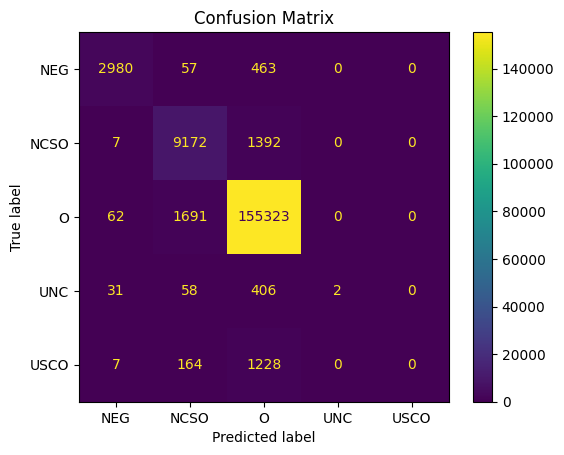

Accuracy: 96.78%
Classification Report:
              precision    recall  f1-score   support

         NEG       0.97      0.85      0.90      3500
        NSCO       0.82      0.87      0.84     10571
           O       0.98      0.99      0.98    157076
         UNC       1.00      0.00      0.01       497
        USCO       0.00      0.00      0.00      1399

    accuracy                           0.97    173043
   macro avg       0.75      0.54      0.55    173043
weighted avg       0.96      0.97      0.96    173043



In [ ]:
#wandb.init(project="natural_language", entity = "juliagartor")

model.eval()  # Set the model to evaluation mode

all_val_labels = []
all_predicted_labels = []

for val_inputs, val_labels in val_dataloader:
    batch_inputs_indices.clear()
    batch_labels_indices.clear()

    for token in val_inputs:
        batch_inputs_indices.append(dataset.word_to_index(token))

    for label in val_labels:
        batch_labels_indices.append(dataset.label_to_index(label))

    # Convert batch inputs to a tensor
    batch_inputs_tensor = torch.tensor(batch_inputs_indices)

    # Forward pass
    outputs = model(batch_inputs_tensor)

    # Get the predicted labels
    _, predicted_indices = torch.max(outputs, 1)

    # Convert predicted indices to label format
    predicted_labels = [dataset.index_to_label(index) for index in predicted_indices]

    # Accumulate the labels and predictions
    all_val_labels.extend(val_labels)
    all_predicted_labels.extend(predicted_labels)

# Convert labels to numpy arrays
val_labels_array = np.array(all_val_labels)
predicted_labels_array = np.array(all_predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(val_labels_array, predicted_labels_array)

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)

wandb.log({"Accuracy": accuracy})

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG","NCSO","O","UNC","USCO"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print classification report
print("Classification Report:")
print(classification_report(val_labels_array, predicted_labels_array,zero_division=0))

In [ ]:
wandb.finish()

Accuracy,▁
Loss,█████▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Accuracy,0.96783
Loss,0.93002


- Problems and solutions

- Problems and solutions

The current accuracy of the model cannot be solely relied upon due to its high value, which is primarily a result of classifying all tokens as "OTHER" due to the prevalence of this label. To address this issue, we need to introduce changes to the loss function to assign different weights to the different classes.

We will use two cross-entropy loss functions: `criterion_specific` and `criterion_full`. The `ignore_index` parameter in `criterion_specific` is set to 0, indicating that the loss calculation should ignore tokens labeled as "OTHER". 

To determine the overall loss, we compute `loss_full` using `criterion_full` with all tokens included and `loss_specific` using `criterion_specific` without considering tokens labeled as "OTHER". We will calculate the weighted sum of `loss_full` and `loss_specific` using weights of 0.2 and 0.8, respectively.

This approach aims to address the imbalanced distribution of labels and assign higher importance to the specific classes while still considering the overall classification performance.

We will be using the parameters of the best run in the previous section.

In [ ]:
batch_size = 64
embedding_dim = 100
hidden_dim = 150
num_classes = 5  # NEG, UNC, NSCO, USCO, and O.
num_epochs = 20
vocab_size = len(dataset.vocab)

model = NegationDetectionModel(vocab_size, embedding_dim, hidden_dim, num_classes)

In [ ]:
wandb.login()

True

In [ ]:
import math

In [ ]:
wandb.init(project="natural_language", entity = "juliagartor")

# Log the hyperparameters
config = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
}
wandb.config.update(config)

In [ ]:
criterion_specific = nn.CrossEntropyLoss(ignore_index = 0)
criterion_full = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [ ]:
dataset.label_to_index("O")

0

In [ ]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for batch_inputs, batch_labels in train_dataloader:

        batch_inputs_indices.clear()
        batch_labels_indices.clear()

        for token in batch_inputs:
          batch_inputs_indices.append(dataset.word_to_index(token))

        for label in batch_labels:
            batch_labels_indices.append(dataset.label_to_index(label))
        
        #print(batch_inputs_indices)
        #print(batch_labels_indices)

        # Convert batch inputs and labels to tensors
        batch_inputs_tensor = torch.tensor(batch_inputs_indices)
        batch_labels_tensor = torch.tensor(batch_labels_indices)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs_tensor)

        # Compute the loss
        loss_full = criterion_full(outputs, batch_labels_tensor)
        loss_specific = criterion_specific(outputs, batch_labels_tensor)
        if math.isnan(loss_specific):
          loss = loss_full
        else:
          loss = loss_full*0.2 + loss_specific*0.8
          #print("Specific")

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)

    # Log the loss for the current epoch
    wandb.log({"Loss": average_loss})

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")


Epoch 1/20, Loss: 1.0747951004411695
Epoch 2/20, Loss: 1.028501805887949
Epoch 3/20, Loss: 1.0151405995987224
Epoch 4/20, Loss: 0.9997297625702161
Epoch 5/20, Loss: 0.9835482357874424
Epoch 6/20, Loss: 0.9699832730700632
Epoch 7/20, Loss: 0.9596446740424492
Epoch 8/20, Loss: 0.952377402725128
Epoch 9/20, Loss: 0.9487269821207551
Epoch 10/20, Loss: 0.94333826737291
Epoch 11/20, Loss: 0.940726254091284
Epoch 12/20, Loss: 0.9383280211343215
Epoch 13/20, Loss: 0.936754653858539
Epoch 14/20, Loss: 0.9358241759549232
Epoch 15/20, Loss: 0.9345622957854934
Epoch 16/20, Loss: 0.9323756454964361
Epoch 17/20, Loss: 0.9316863300796796
Epoch 18/20, Loss: 0.931080441216569
Epoch 19/20, Loss: 0.9301596939255147
Epoch 20/20, Loss: 0.92976673560206


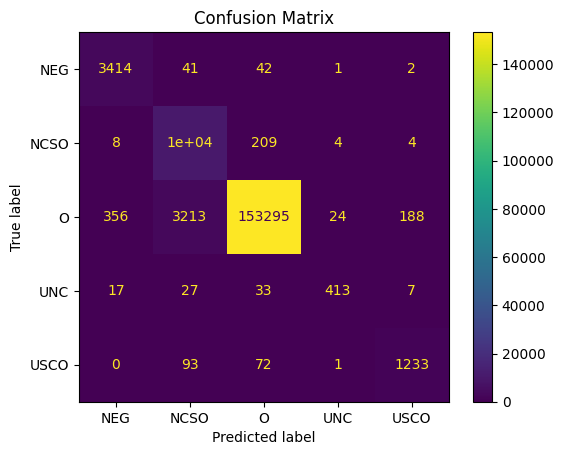

Accuracy: 97.49%
Classification Report:
              precision    recall  f1-score   support

         NEG       0.90      0.98      0.94      3500
        NSCO       0.75      0.98      0.85     10571
           O       1.00      0.98      0.99    157076
         UNC       0.93      0.83      0.88       497
        USCO       0.86      0.88      0.87      1399

    accuracy                           0.97    173043
   macro avg       0.89      0.93      0.90    173043
weighted avg       0.98      0.97      0.98    173043



In [ ]:
#wandb.init(project="natural_language", entity = "juliagartor")

model.eval()  # Set the model to evaluation mode

all_val_labels = []
all_predicted_labels = []

for val_inputs, val_labels in val_dataloader:
    batch_inputs_indices.clear()
    batch_labels_indices.clear()

    for token in val_inputs:
        batch_inputs_indices.append(dataset.word_to_index(token))

    for label in val_labels:
        batch_labels_indices.append(dataset.label_to_index(label))

    # Convert batch inputs to a tensor
    batch_inputs_tensor = torch.tensor(batch_inputs_indices)

    # Forward pass
    outputs = model(batch_inputs_tensor)

    # Get the predicted labels
    _, predicted_indices = torch.max(outputs, 1)

    # Convert predicted indices to label format
    predicted_labels = [dataset.index_to_label(index) for index in predicted_indices]

    # Accumulate the labels and predictions
    all_val_labels.extend(val_labels)
    all_predicted_labels.extend(predicted_labels)

# Convert labels to numpy arrays
val_labels_array = np.array(all_val_labels)
predicted_labels_array = np.array(all_predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(val_labels_array, predicted_labels_array)

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)

wandb.log({"Accuracy": accuracy})

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG","NCSO","O","UNC","USCO"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print classification report
print("Classification Report:")
print(classification_report(val_labels_array, predicted_labels_array,zero_division=0))

In [ ]:
wandb.finish()

With the modification of the loss function, the model has shown significant improvement, as evidenced by the following examples and the observed changes in the confusion matrix. The updated loss function, which assigns different weights to the classes, has effectively addressed the issue of imbalanced label distribution and improved the overall performance of the model.

- Qualitative results

This function will make the results more visible, the text is displayed and each word is colored depending on its predictied label.

In [ ]:
def colorize_tokens(tokens, labels):
    colored_tokens = []

    for token, label in zip(tokens, labels):
        if label == "NEG":
            colored_tokens.append(f"{Fore.RED}{token}{Style.RESET_ALL}")
        elif label == "NSCO":
            colored_tokens.append(f"{Fore.BLUE}{token}{Style.RESET_ALL}")
        elif label == "UNC":
            colored_tokens.append(f"{Fore.YELLOW}{token}{Style.RESET_ALL}")
        elif label == "USCO":
            colored_tokens.append(f"{Fore.GREEN}{token}{Style.RESET_ALL}")
        else:
            colored_tokens.append(token)

    colored_string = " ".join(colored_tokens)
    wrapped_string = textwrap.fill(colored_string, width=180)

    print(f"{Fore.RESET}- Negation cues are represented with {Fore.RED}RED")
    print(f"{Fore.RESET}- Negation scopes are represented with {Fore.BLUE}BLUE")
    print(f"{Fore.RESET}- Uncertainty cues are represented with {Fore.YELLOW}YELLOW")
    print(f"{Fore.RESET}- Uncertainty scopes are represented with {Fore.GREEN}GREEN")
    print("\n")

    print(wrapped_string)


Take some random texts from the data (not from the training data), see how the model behaves. 

In [ ]:
random_number = random.randint(90, 313)
input = data[random_number]["data"]["text"]
#input = cut_text(data[random_number]["data"]["text"])
doc = nlp(input)

tokens = ["<start>"] + [token.text for token in doc] + ["<end>"]
tokens_indices = [dataset.word_to_index(token) for token in tokens]

input_tensor = torch.tensor(tokens_indices)

predicted_idx = model(input_tensor)
_, predicted_idx = torch.max(predicted_idx, 1)

predicted_labels = [dataset.index_to_label(index) for index in predicted_idx]

In [ ]:
colored_output = colorize_tokens(tokens, predicted_labels)

- Negation cues are represented with RED
- Negation scopes are represented with BLUE
- Uncertainty cues are represented with YELLOW
- Uncertainty scopes are represented with GREEN


<start> nº historia clinica : ** *** *** nºepisodi : ******** sexe : home data de naixement : 20.02.1949 edat : 68 anys procedencia domicil/res .soc servei pneumologia data
d'ingres 30.01.2018 data d'alta 08.02.2018 09:47:42 ates per equipo dra . ********* ( ********* , ********* , ********* ) informe d'alta d'hospitalitzacio motiu d'ingres varon de
68 años que ingresa en neurocirugia el 30/01 bajo sospecha de hidrocefalia cronica de el adulto para
monitorizacion y registro de la presion intracraneal y que se traslada a neumologia el 03/02 por hallazgo en tc de cuello y torax de masa pulmonar de cara a completar
estudio . antecedents - sin alergias medicamentosas conocidas . - fumador de 2 paquetes/dia durante mas de 50 años ( fe 100 paq/año ) .
- alcohol : 1 copa de vino diaria y 7 cervezas a el dia ( enol

In [ ]:
colored_output = colorize_tokens(tokens, predicted_labels)

- Negation cues are represented with RED
- Negation scopes are represented with BLUE
- Uncertainty cues are represented with YELLOW
- Uncertainty scopes are represented with GREEN


<start> nº historia clinica : ** *** *** nºepisodi : ******** sexe : home data de naixement : 11.01.1926 edat : 92 anys procedencia aguts servei medicina interna 1 data d'ingres
06.06.2018 data d'alta 27.06.2018 16:00:00 ates per equipo dr. *****-dr.****** ( dra. ********* , dra. ***** , dra- ***** ) informe d'alta d'hospitalitzacio motiu d'ingres paciente
de 92 años que ingresa de forma programada para estudio y tratamiento de hemofilia adquirida . antecedents antecedentes personales : - sin alergias
medicamentosas conocidas - no refiere habitos toxicos antecedentes patologicos - hipertension arterial en tratamiento .
complicacion en forma de cardiopatia hipertensiva e insuficiencia cardiaca diastolica que debuto como un episodio de insuficiencia cardiaca . no disponemos
de informes , - epoc gold ii en tra

In [ ]:
colored_output = colorize_tokens(tokens, predicted_labels)

- Negation cues are represented with RED
- Negation scopes are represented with BLUE
- Uncertainty cues are represented with YELLOW
- Uncertainty scopes are represented with GREEN


<start> nº historia clinica : ** *** *** nºepisodi : ******** sexe : home data de naixement : 10.01.2012 edat : 7 anys procedencia cex mateix hosp servei c. ort i traumatologia ped
data d'ingres 12.09.2019 data d'alta 13.09.2019 18:00:00 ates per *************** , ********* ; ************* , ****** ; ************************************** , ***** informe
d'alta d'hospitalitzacio motiu d'ingres ingres iq proces actual paciente ingresa de foram programada para cirugia multiple de pie derecho y ambas manos exploracio complementaria
no contraindican la cirugia evolucio clinica el dia 12/09/2019 se interviene quirurgicamente a el paciene de exeresis de dedos de la mano
accesorios + correccion de pie varo con transferencia de tibial anterior y fasciotomia plantar , sin incidencias intraoperatorias . se coloca
yes